<a href="https://colab.research.google.com/github/chourouk-sun/NetFlix-PredictionDescription-Length/blob/main/Netflix_Description_Classiffication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# librery & data loading

In [1]:
#  Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import nltk
import re
import string

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving netflix_titles.csv to netflix_titles.csv


In [4]:
df = pd.read_csv("netflix_titles.csv")

In [5]:
#  Target Variable Creation (Long vs Short Description)

desc_len = df['description'].apply(lambda x: len(str(x).split()))
threshold = desc_len.median()

df['desc_length_class'] = desc_len.apply(lambda x: 1 if x > threshold else 0)  # 1 = long, 0 = short


In [6]:
# Preprocessing Function for Description Text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_description'] = df['description'].apply(clean_text)


In [8]:
# Encode Categorical Variables

df['type'] = df['type'].astype(str)
df['listed_in'] = df['listed_in'].astype(str)

le_type = LabelEncoder()
le_genre = LabelEncoder()

df['type_encoded'] = le_type.fit_transform(df['type'])
df['genre_encoded'] = le_genre.fit_transform(df['listed_in'])

In [9]:
# Feature Matrix and Target
X_text = df['clean_description']
X_other = df[['type_encoded', 'genre_encoded']]
y = df['desc_length_class']

# modele

In [11]:
# Train-Test Split
X_train_text, X_test_text, X_train_other, X_test_other, y_train, y_test = train_test_split(
    X_text, X_other, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# TF-IDF on Training Descriptions Only
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [13]:
# Concatenate TF-IDF with Encoded Features
from scipy.sparse import hstack

X_train_full = hstack([X_train_tfidf, X_train_other])
X_test_full = hstack([X_test_tfidf, X_test_other])

In [14]:
#  Apply SMOTE to Train Data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_full, y_train)

In [65]:
pd.Series(y_train_balanced).value_counts(normalize=True)

,proportion
desc_length_class,
0,0.5
1,0.5


In [15]:
# Train Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=1000)

In [16]:
#  Evaluate on Original Test Set
y_pred = model.predict(X_test_full)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[720 318]
 [222 502]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.73      1038
           1       0.61      0.69      0.65       724

    accuracy                           0.69      1762
   macro avg       0.69      0.69      0.69      1762
weighted avg       0.70      0.69      0.70      1762



Class 0 ( “Short”):

True Negatives (TN): 720 — correctly predicted as class 0

False Positives (FP): 318 — incorrectly predicted as class 1

Class 1 (“Long”):

False Negatives (FN): 222 — incorrectly predicted as class 0

True Positives (TP): 502 — correctly predicted as class 1

Text(0.5, 1.0, 'Confusion Matrix - LogisticRegression ')

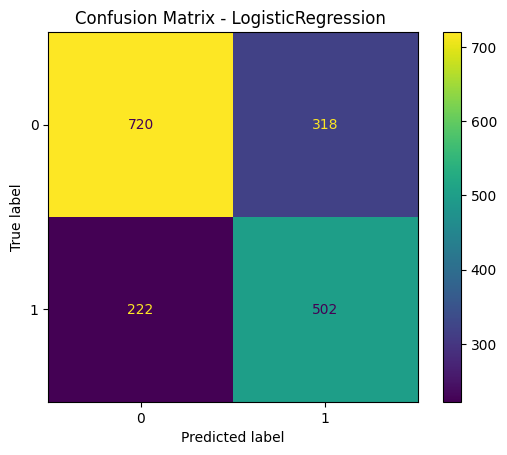

In [47]:
# matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion Matrix - LogisticRegression ')

In [20]:
# trying with different model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

y_pred_rf = rf.predict(X_test_full)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1038
           1       0.62      0.60      0.61       724

    accuracy                           0.68      1762
   macro avg       0.67      0.67      0.67      1762
weighted avg       0.68      0.68      0.68      1762



In [21]:
# trying with different model
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_balanced, y_train_balanced)

y_pred_xgb = xgb.predict(X_test_full)
print(classification_report(y_test, y_pred_xgb))

#xgb

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:05:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.70      0.80      0.75      1038
           1       0.65      0.52      0.57       724

    accuracy                           0.69      1762
   macro avg       0.68      0.66      0.66      1762
weighted avg       0.68      0.69      0.68      1762



Text(0.5, 1.0, 'Confusion Matrix -  XGB')

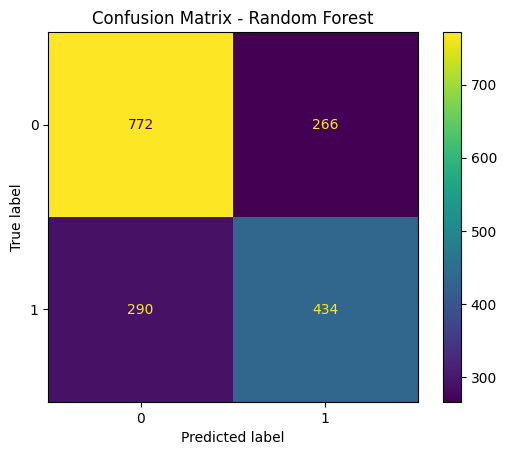

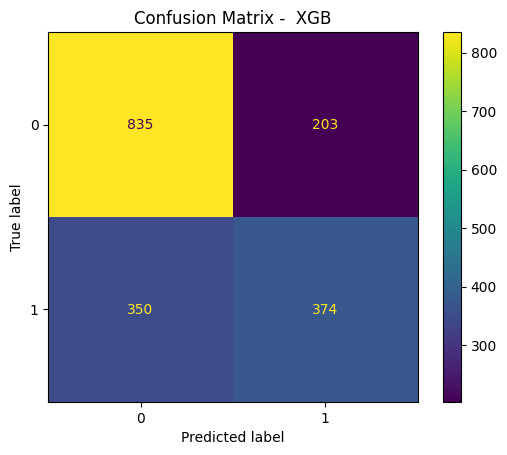

In [53]:
# random forest
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Confusion Matrix - Random Forest')

# xgboost matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)
plt.title('Confusion Matrix -  XGB')

# evaluation

In [26]:
# This must be fitted on training data FIRST
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train_text)  # fit happens here
X_test_tfidf = tfidf.transform(X_test_text)


In [27]:
# Example input
new_data = pd.DataFrame({
    'type': ['Movie'],
    'listed_in': ['Documentaries'],
    'description': ['This is a story about the struggles of a small town in the 1960s.']
})

# Preprocessing
new_data['clean_description'] = new_data['description'].apply(clean_text)
new_data['type_encoded'] = le_type.transform(new_data['type'])
new_data['main_genre'] = new_data['listed_in'].apply(lambda x: x.split(',')[0].strip())
new_data['genre_encoded'] = le_genre.transform(new_data['main_genre'])

# TF-IDF + features
desc_tfidf = tfidf.transform(new_data['clean_description'])
meta = new_data[['type_encoded', 'genre_encoded']]
final_input = hstack([desc_tfidf, meta])

# Predict
prediction = model.predict(final_input)
print("Prediction:", "Long" if prediction[0] == 1 else "Short")


Prediction: Long


In [28]:
print("Median description length:", threshold)

Median description length: 24.0


In [29]:
examples = [
    "A young man finds his calling in the heart of New York City.",
    "An epic journey spanning 3 continents and generations of family history.",
    "In a world where magic is forbidden, a girl discovers her hidden powers and sparks a revolution that changes her kingdom forever.",
    "Two friends start a podcast in their garage."
]

for desc in examples:
    new_data = pd.DataFrame({
        'type': ['Movie'],
        'listed_in': ['Dramas'],
        'description': [desc]
    })

    new_data['clean_description'] = new_data['description'].apply(clean_text)
    new_data['type_encoded'] = le_type.transform(new_data['type'])
    new_data['main_genre'] = new_data['listed_in'].apply(lambda x: x.split(',')[0].strip())
    new_data['genre_encoded'] = le_genre.transform(new_data['main_genre'])

    desc_tfidf = tfidf.transform(new_data['clean_description'])
    meta = new_data[['type_encoded', 'genre_encoded']]
    final_input = hstack([desc_tfidf, meta])

    prediction = model.predict(final_input)
    print(f"{desc[:60]}... → Prediction: {'Long' if prediction[0]==1 else 'Short'} (Word count: {len(desc.split())})")


A young man finds his calling in the heart of New York City.... → Prediction: Short (Word count: 13)
An epic journey spanning 3 continents and generations of fam... → Prediction: Short (Word count: 11)
In a world where magic is forbidden, a girl discovers her hi... → Prediction: Long (Word count: 22)
Two friends start a podcast in their garage.... → Prediction: Short (Word count: 8)


In [30]:
def predict_description_length(desc, content_type='Movie', genre='Dramas'):
    new_data = pd.DataFrame({
        'type': [content_type],
        'listed_in': [genre],
        'description': [desc]
    })

    new_data['clean_description'] = new_data['description'].apply(clean_text)
    new_data['type_encoded'] = le_type.transform(new_data['type'])
    new_data['main_genre'] = new_data['listed_in'].apply(lambda x: x.split(',')[0].strip())
    new_data['genre_encoded'] = le_genre.transform(new_data['main_genre'])

    desc_tfidf = tfidf.transform(new_data['clean_description'])
    meta = new_data[['type_encoded', 'genre_encoded']]
    final_input = hstack([desc_tfidf, meta])

    prediction = model.predict(final_input)
    print(f"Description: \"{desc}\"")
    print(f"Prediction: {'Long' if prediction[0]==1 else 'Short'} (Word count: {len(desc.split())})")


In [35]:
predict_description_length("A royal chef discovers a conspiracy inside the palace walls.")


Description: "A royal chef discovers a conspiracy inside the palace walls."
Prediction: Short (Word count: 10)
